In [1]:
import json
import os
import pandas as pd

train_file_path = "datasets\\DuRecDial\\en_train.txt"
with open(train_file_path, "r", encoding="utf-8") as f:
    train_data_txt = f.readlines()
train_data = [json.loads(line) for line in train_data_txt]

dev_file_path = "datasets\\DuRecDial\\en_dev.txt"
with open(dev_file_path, "r", encoding="utf-8") as f:
    dev_data_txt = f.readlines()
dev_data = [json.loads(line) for line in dev_data_txt]

test_file_path = "datasets\\DuRecDial\\en_test.txt"
with open(test_file_path, "r", encoding="utf-8") as f:
    test_data_txt = f.readlines()
test_data = [json.loads(line) for line in test_data_txt]

In [2]:
user_set = set([conv["user_profile"]["Name"] for conv in train_data + dev_data + test_data])
user_id2name = {}
user_name2id = {}
for user_id, user_name in enumerate(user_set):
    user_id2name[user_id] = user_name
    user_name2id[user_name] = user_id

In [3]:
# load movie info
df = pd.read_csv("lab.dataset\\DuRecDial\\movies_with_mentions.csv", encoding="ANSI")
movie_id2name = {}
movie_name2id = {}
for index, row in df.iterrows():
    movie_id = row["movie_id"]
    movie_name = row["movie_name"]
    movie_id2name[movie_id] = movie_name
    movie_name2id[movie_name] = movie_id

In [4]:
# process user profile
user_data = {}

for conv in train_data:
    profile = conv["user_profile"]
    user_id = user_name2id[profile["Name"]]

    if user_id not in user_data.keys():
        user_data[user_id] = {"user_id": user_id, "movies": []}
    if "Accepted movies" in profile.keys():
        user_data[user_id]["movies"] += profile["Accepted movies"]
    if "Accepted movie" in profile.keys():
        user_data[user_id]["movies"] += profile["Accepted movie"]

    user_data[user_id]["movies"] = list(set(user_data[user_id]["movies"]))  # remove duplicates

In [5]:
# check how many movies in user profile are mentioned in dialog
movie_in_profile_count = 0

for conv in train_data:

    user_id = user_name2id[conv["user_profile"]["Name"]]

    for movie in movie_name2id.keys():

        for uttr in conv:

            if movie in uttr and movie in user_data[user_id]["movies"]:

                movie_in_profile_count += 1

                break

print(f"Number of movies mentioned in dialog and in user profile: {movie_in_profile_count}")

# *** conlusion: no movie in user profile is mentioned in dialog ***

Number of movies mentioned in dialog and in user profile: 0


In [6]:
# check how many movies in user profile are in movie lis
profile_movie_in_count = 0

all_profile_movie_count = 0

for user_id in user_data.keys():

    for movie in user_data[user_id]["movies"]:

        all_profile_movie_count += 1

        if movie in movie_name2id.keys():

            profile_movie_in_count += 1

print(

    f"Number of movies in user profile and in movie list: {profile_movie_in_count}/{all_profile_movie_count}"

)

Number of movies in user profile and in movie list: 2944/5499


In [7]:
# filter profile movies not in movie list
for user_id in user_data.keys():
    filtered_movies = []
    for movie in user_data[user_id]["movies"]:
        if movie in movie_name2id.keys():
            filtered_movies.append(movie)
    user_data[user_id]["movies"] = filtered_movies

profile_movie_in_count = 0
all_profile_movie_count = 0
for user_id in user_data.keys():
    for movie in user_data[user_id]["movies"]:
        all_profile_movie_count += 1
        if movie in movie_name2id.keys():
            profile_movie_in_count += 1
print(
    f"Number of movies in user profile and in movie list: {profile_movie_in_count}/{all_profile_movie_count}"
)

Number of movies in user profile and in movie list: 2944/2944


Total number of users: 736
Number of users with 0 movies: 255
Number of users with 1~3 movie: 71


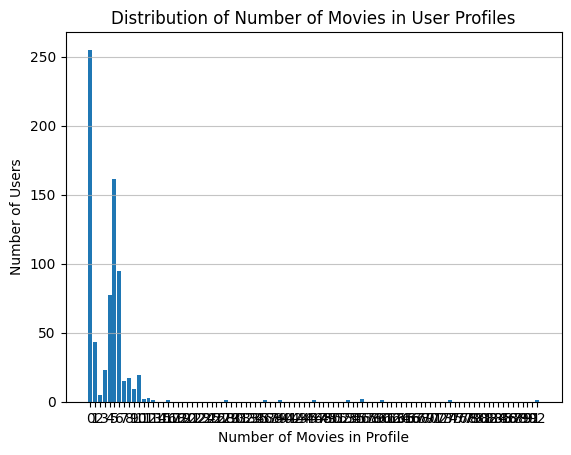

In [8]:
# 函数 计算电影数为x的用户数
def count_users_with_x_movies(x):
    count = 0
    for user_id in user_data.keys():
        if len(user_data[user_id]["movies"]) == x:
            count += 1
    return count


print("Total number of users:", len(user_data))
print("Number of users with 0 movies:", count_users_with_x_movies(0))
print(
    "Number of users with 1~3 movie:",
    count_users_with_x_movies(1) + count_users_with_x_movies(2) + count_users_with_x_movies(3),
)

# 电影数分布直方图
import matplotlib.pyplot as plt

movie_counts = [len(user_data[user_id]["movies"]) for user_id in user_data.keys()]
plt.hist(movie_counts, bins=range(0, max(movie_counts) + 2), align="left", rwidth=0.8)
plt.xlabel("Number of Movies in Profile")
plt.ylabel("Number of Users")
plt.title("Distribution of Number of Movies in User Profiles")
plt.xticks(range(0, max(movie_counts) + 1))
plt.grid(axis="y", alpha=0.75)
plt.show()